# Install important library

In [1]:
pip install rouge-score sacrebleu evaluate torchsummary

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6a60180ddb62a8a183d9f4743fab944a94dbe4e766ad9fcfbacc607f51e66282
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


# Import Library

In [2]:
import torch
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from transformers import BertTokenizer, BertModel, EncoderDecoderModel, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

from datasets import Dataset
from sklearn.model_selection import train_test_split

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torchsummary import summary

from collections import defaultdict
warnings.filterwarnings("ignore")

# Cleaning Data

In [3]:
#Load Data
df = pd.read_csv('/kaggle/input/layoutlm/medquad.csv')

# Sampel Data
print("Data Sample")
print(df.head())

#Null value
print("Null Value Data")
print(df.isnull().sum())

# List of question words
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Ensure questions are lowercase for consistent filtering
df['question'] = df['question'].str.lower()

# Filter rows where the question starts with a question word
df = df[df['question'].str.split().str[0].isin(question_words)]

df = df.reset_index(drop=True)

# Check for duplicate rows
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

#Delete Unused column
df = df.drop(columns=['source', 'focus_area'])

#Table Info
print("Table Info")
print(df.info())

# Apply the function
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

#Drop rows with null values
df = df.drop_duplicates(subset=['question', 'answer']).reset_index(drop=True)
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

# Removing "(are)" in the dataset
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r'\s+', ' ', text.strip().lower())
    return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

#Checking again of null values
print("Null Value Data")
print(df.isnull().sum())

#Check for Unique Data
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

#Checking again of the data info
df.info()
df.head()

Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Number of duplicate rows: 48
Table Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1

,question,answer
0,what is glaucoma ?,glaucoma is a group of diseases that can damag...
1,what causes glaucoma ?,"nearly 2.7 million people have glaucoma, a lea..."
2,what are the symptoms of glaucoma ?,symptoms of glaucoma glaucoma can develop in o...
3,what are the treatments for glaucoma ?,"although open-angle glaucoma cannot be cured, ..."
4,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...


# Architecting Model

In [ ]:
# Load BioBERT tokenizer and model
encoder_name = "dmis-lab/biobert-base-cased-v1.1"
decoder_name = "bert-base-cased"  

# Load Tokenizers for both Encoder and Decoder
tokenizer = BertTokenizer.from_pretrained(encoder_name)
decoder_tokenizer = BertTokenizer.from_pretrained(decoder_name)

# Define Encoder-Decoder model
model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_name, decoder_name)

# Tie weights between encoder and decoder embeddings (optional)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 128
model.config.min_length = 2
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 1.5
model.config.early_stopping = True

# Enable dropout in both encoder and decoder for regularization
model.encoder.config.hidden_dropout_prob = 0.3
model.encoder.config.attention_probs_dropout_prob = 0.3
model.decoder.config.hidden_dropout_prob = 0.3
model.decoder.config.attention_probs_dropout_prob = 0.3

# Print the model architecture
def summarize_model_by_type(model):
    layer_summary = defaultdict(int)
    param_summary = defaultdict(int)

    for name, module in model.named_modules():
        layer_type = type(module).__name__
        layer_summary[layer_type] += 1
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())

    print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}")
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)

# Preprocess function for seq2seq
def preprocess_function(batch):
    inputs = [f"question: {str(q)}" for q in batch['question']]
    targets = [f"{str(a)}" for a in batch['answer']]
    
    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=160,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
        return_attention_mask=True
    )
    
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = decoder_tokenizer(
            targets,
            max_length=80,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
    
    labels_ids = labels['input_ids'].clone()
    labels_ids[labels_ids == tokenizer.pad_token_id] = -100
    model_inputs['labels'] = labels_ids

    return model_inputs

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Preprocess datasets
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=16,  
    remove_columns=train_dataset.column_names,
    num_proc=2,   
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=16,  
    remove_columns=val_dataset.column_names,
    num_proc=2,  
)

# Define TrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    # eval_steps=500,
    # save_steps=1000,
    save_total_limit=3,
    learning_rate=3e-5,
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=50,
    group_by_length=True, 
    # load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none",
    fp16=True
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model,
    padding='longest',
)

# Step 6: Define compute_metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Decode predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Compute metrics
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")
    
    bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {
        "bleu": bleu_score['bleu'],
        "rouge": rouge_score['rougeL']
    }

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # processing_class=BertTokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train and Save Model
trainer.train()
trainer.save_model("./biobert_seq2seq_model")
tokenizer.save_pretrained("./biobert_seq2seq_tokenizer")

# Save log history
log_history = trainer.state.log_history

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.enc

Layer Type                    Count     Parameters     
EncoderDecoderModel           1         245,017,924    
BertModel                     2         244,396,800    
BertEmbeddings                2         45,330,432     
Embedding                     6         45,327,360     
LayerNorm                     63        96,768         
Dropout                       98        0              
BertEncoder                   2         198,475,776    
ModuleList                    2         198,475,776    
BertLayer                     24        198,475,776    
BertAttention                 36        85,100,544     
BertSdpaSelfAttention         36        63,783,936     
Linear                        195       221,862,724    
BertSelfOutput                36        21,316,608     
BertIntermediate              24        56,696,832     
GELUActivation                25        0              
BertOutput                    24        56,678,400     
BertPooler                    1         590,592 

Map (num_proc=2):   0%|          | 0/11086 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2772 [00:00<?, ? examples/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss,Bleu,Rouge
0,3.280000,2.788935,0.173914,0.275969
1,2.671200,2.332994,0.208389,0.309192
2,2.284900,2.144887,0.208510,0.313504
4,1.961300,1.948641,0.234184,0.340562
5,1.875300,1.905608,0.236343,0.344627
6,1.809500,1.893080,0.237290,0.344190
7,1.773300,1.884970,0.237533,0.346215


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

# Show graphics

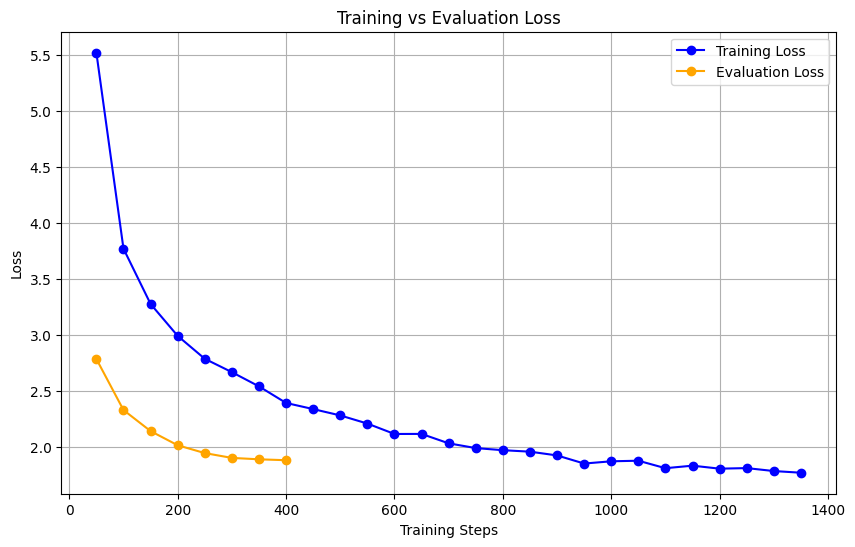

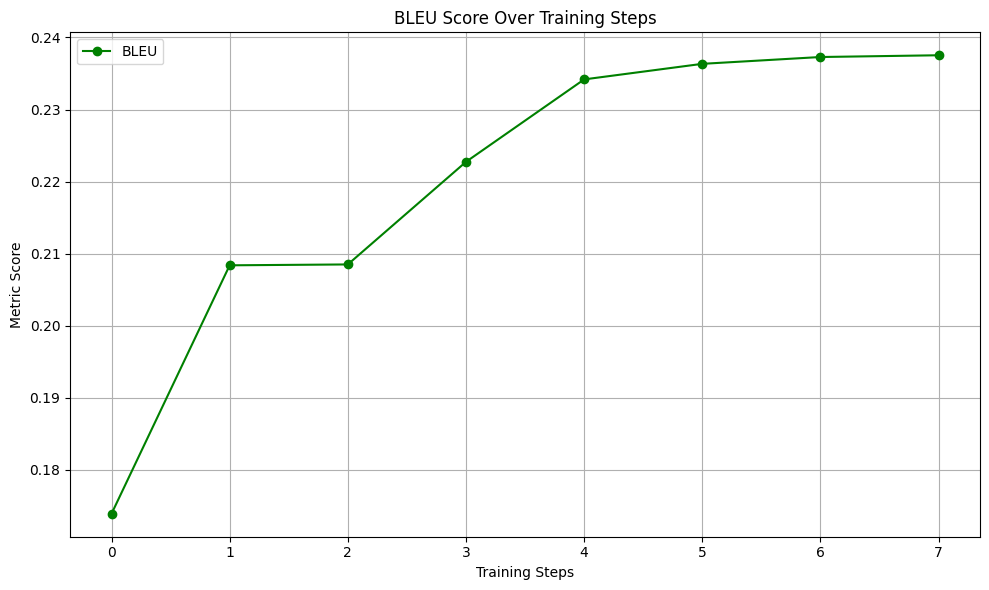

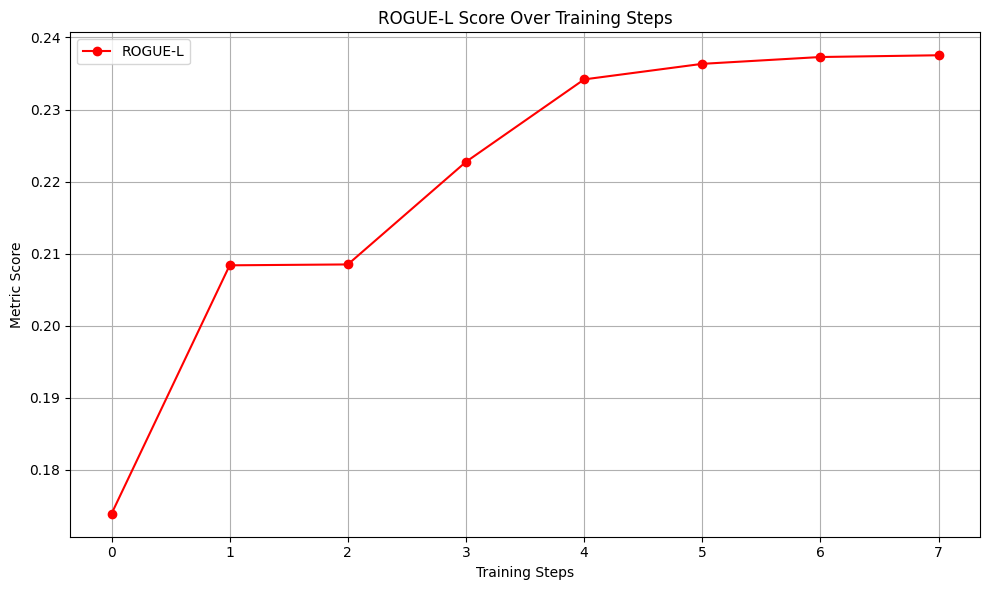

In [9]:
# Extract loss values from log history
train_loss = []
eval_loss = []
eval_bleu = []
eval_rogue = []
steps = []
eval_steps = []

for log in log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_bleu" in log:
        eval_bleu.append(log["eval_bleu"])
    if "eval_rougeL" in log:
        eval_rogue.append(log["eval_rougeL"])

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue", marker="o")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", color="orange", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot the BLEU
plt.figure(figsize=(10, 6))
plt.plot(eval_bleu, label="BLEU", marker="o", linestyle="-", color="green")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("BLEU Score Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the ROGUE
plt.figure(figsize=(10, 6))
plt.plot(eval_bleu, label="ROGUE-L", marker="o", linestyle="-", color="red")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("ROGUE-L Score Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing using Input

In [12]:
from transformers import BertTokenizer
import torch

def get_response(input_text, model, tokenizer, max_length=64, num_beams=5):
    # Tokenize the input text with robust handling
    inputs = tokenizer(
        f"question: {input_text}",
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding="max_length"
    )
    
    # Generate response using the model
    model.eval()  
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True,
            no_repeat_ngram_size=2,  
            temperature=0.7,  
        )
    
    # Decode and clean the response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

# Example Usage:
# Load fine-tuned model and tokenizer
model_path = "/kaggle/working/biobert_seq2seq_model"
tokenizer_path = "/kaggle/working/biobert_seq2seq_tokenizer"
model = EncoderDecoderModel.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# Get a response from the model
question = "what is diabetes?"
response = get_response(question, model, tokenizer)
print("Response:", response)


Response: diabetes is a disease in which your blood glucose is too high. it can affect your body's ability to function normally. if you have diabetes, you can lose weight, or lose more weight. you may not have any symptoms, but they can lead to serious complications such as heart disease, heart failure,
